In [1]:
import os
import shutil
import random as rd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

## Dataset

In [2]:
healthy = os.listdir('POTATOES/healthy')
damaged = os.listdir('POTATOES/damaged')

rd.shuffle(healthy)
rd.shuffle(damaged)

print('Total healthy images:', len(healthy))
print('Total damaged images:', len(damaged))

Total healthy images: 327
Total damaged images: 200


In [3]:
train_size = 150
test_size = 30
validation_size = 20

dataset = {
    'train': {
        'healthy': healthy[:train_size],
        'damaged': damaged[:train_size],
    },
    'test': {
        'healthy': healthy[train_size:train_size+test_size],
        'damaged': damaged[train_size:train_size+test_size],
    },
    'validation': {
        'healthy': healthy[train_size+test_size:train_size+test_size+validation_size],
        'damaged': damaged[train_size+test_size:train_size+test_size+validation_size],
    },
}

In [4]:
# Define root directory
src_dir = './POTATOES'
dst_dir = './dataset'


# Empry directory
if os.path.exists(dst_dir): shutil.rmtree(dst_dir)

for group in ['train', 'test', 'validation']:
    for label in ['healthy', 'damaged']:
        # Generate paths
        os.makedirs(dst_dir + '/' + group + '/' + label)
        # Create new dataset
        for filename in dataset[group][label]:
            shutil.copy(
                src_dir + '/' + label + '/' + filename,
                dst_dir + '/' + group + '/' + label + '/' + filename,
            )

In [5]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(directory=dst_dir + '/train',
                                                    class_mode='binary',
                                                    batch_size=10,
                                                    target_size=(250, 250))

# Flow testing images in batches of 10 using test_datagen generator
test_generator =  train_datagen.flow_from_directory(directory=dst_dir + '/test',
                                                    class_mode  = 'binary',
                                                    batch_size=10,
                                                    target_size = (250, 250))

Found 300 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


## Model

In [6]:
model = tf.keras.models.Sequential([
    # Conv layers
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(250,250,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten layer
    tf.keras.layers.Flatten(),
    # Fully connected layers
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    # Output neuron
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 64)       0

In [8]:
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics = ['accuracy'])

## Training

In [9]:
history = model.fit(train_generator,
                    epochs=15,
                    steps_per_epoch=len(train_generator),
                    validation_data=test_generator,
                    validation_steps=len(test_generator))

Epoch 1/15
30/30 [==============================] - 20s 642ms/step - loss: 1.3242 - accuracy: 0.5567 - val_loss: 0.5605 - val_accuracy: 0.8500
Epoch 2/15
30/30 [==============================] - 19s 643ms/step - loss: 0.5535 - accuracy: 0.7700 - val_loss: 0.4259 - val_accuracy: 0.7667
Epoch 3/15
30/30 [==============================] - 21s 702ms/step - loss: 0.5164 - accuracy: 0.7767 - val_loss: 0.4948 - val_accuracy: 0.8167
Epoch 4/15
30/30 [==============================] - 18s 600ms/step - loss: 0.4855 - accuracy: 0.7900 - val_loss: 0.8060 - val_accuracy: 0.5333
Epoch 5/15
30/30 [==============================] - 20s 662ms/step - loss: 0.4253 - accuracy: 0.8000 - val_loss: 0.3861 - val_accuracy: 0.8167
Epoch 6/15
30/30 [==============================] - 22s 714ms/step - loss: 0.3613 - accuracy: 0.8333 - val_loss: 0.4152 - val_accuracy: 0.8000
Epoch 7/15
30/30 [==============================] - 19s 649ms/step - loss: 0.3787 - accuracy: 0.8233 - val_loss: 0.3432 - val_accuracy: 0.8000

## Prediction

[1.]
./dataset/validation/healthy/img_0855.jpg
Healthy


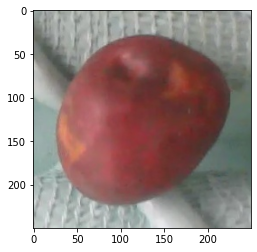

In [10]:
validation_images = ['./dataset/validation/damaged/' + img for img in os.listdir('./dataset/validation/damaged')]
validation_images += ['./dataset/validation/healthy/' + img for img in os.listdir('./dataset/validation/healthy')]

path = rd.choice(validation_images)
test_img = image.load_img(path, target_size=(250,250))

plt.imshow(test_img)

x = image.img_to_array(test_img)
x /= 255
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

classes = model.predict(images, batch_size=1)



print(classes[0])
print(path)
print('Healthy' if classes[0] > 0.5 else 'Damaged')

## Accuracy and Loss evaluation

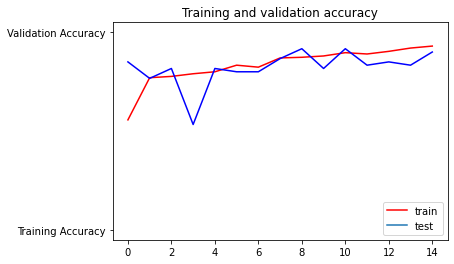

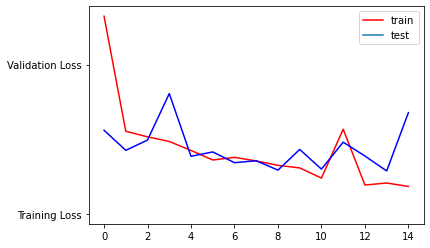

In [11]:
# Retrieve a list of list results on training and test data sets for each training epoch
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.legend(['train', 'test'])
plt.title('Training and validation accuracy')
plt.show()
print("")

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.legend(['train', 'test'])
plt.show()

## Save trained model

In [12]:
model.save_weights('./checkpoints/last_training')